# Combined labels for both cells and nuclei for brain_s0
# Version with late fusion PCA

In [1]:
slide_id = "brain_s0"

In [2]:
import pandas as pd
import scanpy as sc
import spatialdata as sd
import numpy as np
import anndata as ad
from spatialdata.models import get_table_keys
from matplotlib.colors import to_rgba
from functools import partial
from matplotlib import colors
import gc

## 1. Load the data

In [3]:
sdata_final = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('tables',))

cellid2transcript_cat = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'transcript_cat']].values)

cellid2nucleilabel = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'final_label']].values)
cellid2celllabel = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'final_label']].values)

cellid2nucleilabel1 = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'label1']].values)
cellid2celllabel1 = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'label1']].values)

del sdata_final
gc.collect()

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


1215

In [4]:
sdata_processed = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_{slide_id}.zarr", selection=('tables',))
sdata_processed

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_brain_s0.zarr
└── Tables
      ├── 'table_cells': AnnData (809076, 480)
      └── 'table_nuclei': AnnData (809076, 541)
with coordinate systems:

with the following elements in the Zarr store but not in the SpatialData object:
    ▸ morpho (Images)
    ▸ nucleus_boundaries (Shapes)
    ▸ he (Images)
    ▸ cell_boundaries (Shapes)
    ▸ st (Points)

In [5]:
adata_nuclei_ini = sdata_processed.tables['table_nuclei'].copy()
adata_nuclei_ini

AnnData object with n_obs × n_vars = 809076 × 541
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial', 'tangram_pred'

In [6]:
adata_nuclei_ini.var

Empty DataFrame
Columns: []
Index: [A2M, ACE2, ACKR1, ACTA2, ACTB, ACTG2, ADAM28, ADAMTS1, AGER, AGR3, AHSP, AIF1, AIRE, AKT1, ANPEP, ANXA1, APOE, AQP2, AQP3, AQP8, AREG, ARG1, ARID1A, ARPC3, ARPC5, ASCL3, ASPN, ATM, BANK1, BATF3, BCL2, BRAF, C15orf48, C1QB, C1QBP, C1R, C1S, C1orf194, C20orf85, C7, CA4, CAV1, CAVIN2, CCL11, CCL13, CCL14, CCL15, CCL16, CCL19, CCL2, CCL20, CCL21, CCL26, CCL28, CCL3, CCL3L1, CCL4, CCL5, CCL7, CCL8, CCND1, CCR1, CCR2, CCR3, CCR4, CCR5, CCR6, CCR7, CD14, CD163, CD19, CD1A, CD1C, CD2, CD247, CD27, CD274, CD276, CD28, CD37, CD38, CD3D, CD3E, CD4, CD40, CD40LG, CD44, CD45RA, CD45RO, CD47, CD68, CD69, CD74, CD79A, CD79B, CD80, CD83, CD86, CD8A, CD8B, ...]

[541 rows x 0 columns]

In [7]:
adata_cells_ini = sdata_processed.tables['table_cells'].copy()
adata_cells_ini

AnnData object with n_obs × n_vars = 809076 × 480
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [8]:
adata_cells_ini.var

gene_ids    feature_types   genome
A2M     ENSG00000175899  Gene Expression  Unknown
ACE2    ENSG00000130234  Gene Expression  Unknown
ACKR1   ENSG00000213088  Gene Expression  Unknown
ACTA2   ENSG00000107796  Gene Expression  Unknown
ACTB    ENSG00000075624  Gene Expression  Unknown
...                 ...              ...      ...
VSIG4   ENSG00000155659  Gene Expression  Unknown
VSIR    ENSG00000107738  Gene Expression  Unknown
VWF     ENSG00000110799  Gene Expression  Unknown
XBP1    ENSG00000100219  Gene Expression  Unknown
ZNF683  ENSG00000176083  Gene Expression  Unknown

[480 rows x 3 columns]

In [9]:
# Clean memory
del sdata_processed
gc.collect()

31

## 2. Get adata_nuclei and adata_cyto

In [10]:
adata_cells_ini = adata_cells_ini[adata_cells_ini.obs["transcript_counts"]>10].copy()  # Filter cells with less than 10 transcripts
len(adata_cells_ini.obs)

807761

In [11]:
# Align the cell_id in both AnnData objects
# Create a mapping of cell_id to index position in both objects
nuclei_idx = adata_nuclei_ini.obs.set_index('cell_id').index
cells_idx = adata_cells_ini.obs.set_index('cell_id').index

# Find the intersection of cell_id in both datasets
common_cells = nuclei_idx.intersection(cells_idx)
print(f"Number of common cell_ids: {len(common_cells)}")

# Subset both AnnData objects to include only common cell_ids
adata_nuclei = adata_nuclei_ini[adata_nuclei_ini.obs['cell_id'].isin(common_cells)]
adata_cells = adata_cells_ini[adata_cells_ini.obs['cell_id'].isin(common_cells)]

# Merge the 'obs' dataframes based on 'cell_id' to ensure the same order in both
obs_nuclei = adata_nuclei.obs[['cell_id']].reset_index(drop=True)
obs_cells = adata_cells.obs[['cell_id']].reset_index(drop=True)

# Ensure that both are in the same order
adata_nuclei = adata_nuclei[obs_nuclei['cell_id'].argsort().values]
adata_cells = adata_cells[obs_cells['cell_id'].argsort().values]

# Check that the cell_ids match now
assert np.array_equal(adata_nuclei.obs['cell_id'].values, adata_cells.obs['cell_id'].values), "Cell IDs do not match after alignment."

# Find common genes
common_genes = adata_nuclei.var_names.intersection(adata_cells.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset both AnnData objects to include only the common genes
adata_nuclei = adata_nuclei[:, common_genes]
adata_cells = adata_cells[:, common_genes]

# Remove nucleus RNA from cell RNA to get the cytoplasmic RNA
X_cyto = adata_cells.X - adata_nuclei.X

# Because of slight mismatches or rounding, some entries might go negative by 1 or 2 in real data. So we clip to 0:
X_cyto.data = np.clip(X_cyto.data, a_min=0, a_max=None)

# Create a new AnnData object with the cytoplasmic RNA
adata_cyto = ad.AnnData(
    X=X_cyto,
    obs=adata_cells.obs.copy(),  # or adata_nuclei.obs, they should be the same set
    var=adata_cells.var.copy()   # same genes as well
)

Number of common cell_ids: 807761
Number of common genes: 480


In [12]:
adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)
adata_nuclei.obs

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_54346/547616959.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)


region   slide     cell_id       area  \
aaaaaaaa-1  nucleus_boundaries  morpho  aaaaaaaa-1  41.002191   
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  50.146767   
aaaaaaac-1  nucleus_boundaries  morpho  aaaaaaac-1  39.986850   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1  23.390865   
aaaaaaae-1  nucleus_boundaries  morpho  aaaaaaae-1  42.130546   
...                        ...     ...         ...        ...   
aaamfigm-1  nucleus_boundaries  morpho  aaamfigm-1  24.157193   
aaamfign-1  nucleus_boundaries  morpho  aaamfign-1  16.346013   
aaamfigo-1  nucleus_boundaries  morpho  aaamfigo-1  15.624592   
aaamfiha-1  nucleus_boundaries  morpho  aaamfiha-1   6.570084   
aaamfihc-1  nucleus_boundaries  morpho  aaamfihc-1  19.034179   

                                 ct_tangram  transcript_counts  
aaaaaaaa-1           L5/6 excitatory neuron                169  
aaaaaaab-1           Protoplasmic astrocyte                161  
aaaaaaac-1                  Oligodendrocyte                203  
aaaaaaad-1                 Endothelial cell                 41  
aaaaaaae-1  Oligodendrocyte progenitor cell                179  
...                                     ...                ...  
aaamfigm-1           L2/3 excitatory neuron                 25  
aaamfign-1                 Endothelial cell                 22  
aaamfigo-1                 Endothelial cell                 17  
aaamfiha-1  Oligodendrocyte progenitor cell                 14  
aaamfihc-1                  Oligodendrocyte                 15  

[807761 rows x 6 columns]

In [13]:
adata_cyto.obs["transcript_counts"] = adata_cyto.X.sum(axis=1).astype(int)
adata_cyto.obs

cell_id  transcript_counts  control_probe_counts  \
0       aaaaaaaa-1                 48                     0   
1       aaaaaaab-1                 80                     0   
3       aaaaaaac-1                134                     0   
4       aaaaaaad-1                 38                     0   
5       aaaaaaae-1                 74                     0   
...            ...                ...                   ...   
816761  aaamfigm-1                  6                     0   
816762  aaamfign-1                  2                     0   
816763  aaamfigo-1                 57                     0   
816765  aaamfiha-1                  4                     0   
816767  aaamfihc-1                  4                     0   

        control_codeword_counts  unassigned_codeword_counts  \
0                             0                           0   
1                             0                           0   
3                             0                           0   
4                             0                           0   
5                             0                           0   
...                         ...                         ...   
816761                        0                           0   
816762                        0                           0   
816763                        0                           0   
816765                        0                           0   
816767                        0                           0   

        deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
0                                0           207   60.148127     42.762970   
1                                0           231   78.842815     52.561877   
3                                0           331   82.500472     34.138126   
4                                0            75   43.937033     25.152032   
5                                0           246   67.011877     44.027345   
...                            ...           ...         ...           ...   
816761                           0            28   27.455001     27.455001   
816762                           0            22   17.791563     17.791563   
816763                           0            72  115.690317     17.023907   
816765                           0            16    7.586250      7.586250   
816767                           0            18   24.248907     20.681563   

             region  z_level  nucleus_count  
0       cell_labels      0.0            1.0  
1       cell_labels      0.0            1.0  
3       cell_labels      0.0            2.0  
4       cell_labels      0.0            1.0  
5       cell_labels      0.0            1.0  
...             ...      ...            ...  
816761  cell_labels      5.0            1.0  
816762  cell_labels      5.0            1.0  
816763  cell_labels      4.0            1.0  
816765  cell_labels      5.0            1.0  
816767  cell_labels      4.0            1.0  

[807761 rows x 12 columns]

In [14]:
adata_cells_ini.obs

cell_id  transcript_counts  control_probe_counts  \
0       aaaaaaaa-1                207                     0   
1       aaaaaaab-1                231                     0   
3       aaaaaaac-1                331                     0   
4       aaaaaaad-1                 75                     0   
5       aaaaaaae-1                246                     0   
...            ...                ...                   ...   
816761  aaamfigm-1                 28                     0   
816762  aaamfign-1                 22                     0   
816763  aaamfigo-1                 72                     0   
816765  aaamfiha-1                 16                     0   
816767  aaamfihc-1                 18                     0   

        control_codeword_counts  unassigned_codeword_counts  \
0                             0                           0   
1                             0                           0   
3                             0                           0   
4                             0                           0   
5                             0                           0   
...                         ...                         ...   
816761                        0                           0   
816762                        0                           0   
816763                        0                           0   
816765                        0                           0   
816767                        0                           0   

        deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
0                                0           207   60.148127     42.762970   
1                                0           231   78.842815     52.561877   
3                                0           331   82.500472     34.138126   
4                                0            75   43.937033     25.152032   
5                                0           246   67.011877     44.027345   
...                            ...           ...         ...           ...   
816761                           0            28   27.455001     27.455001   
816762                           0            22   17.791563     17.791563   
816763                           0            72  115.690317     17.023907   
816765                           0            16    7.586250      7.586250   
816767                           0            18   24.248907     20.681563   

             region  z_level  nucleus_count  
0       cell_labels      0.0            1.0  
1       cell_labels      0.0            1.0  
3       cell_labels      0.0            2.0  
4       cell_labels      0.0            1.0  
5       cell_labels      0.0            1.0  
...             ...      ...            ...  
816761  cell_labels      5.0            1.0  
816762  cell_labels      5.0            1.0  
816763  cell_labels      4.0            1.0  
816765  cell_labels      5.0            1.0  
816767  cell_labels      4.0            1.0  

[807761 rows x 12 columns]

In [15]:
adata_nuclei.var

Empty DataFrame
Columns: []
Index: [A2M, ACE2, ACKR1, ACTA2, ACTB, ACTG2, ADAM28, ADAMTS1, AGER, AGR3, AHSP, AIF1, AIRE, AKT1, ANPEP, ANXA1, APOE, AQP2, AQP3, AQP8, AREG, ARG1, ARID1A, ARPC3, ARPC5, ASCL3, ASPN, ATM, BANK1, BATF3, BCL2, BRAF, C15orf48, C1QB, C1QBP, C1R, C1S, C1orf194, C20orf85, C7, CA4, CAV1, CAVIN2, CCL11, CCL13, CCL14, CCL15, CCL16, CCL19, CCL2, CCL20, CCL21, CCL26, CCL28, CCL3, CCL3L1, CCL4, CCL5, CCL7, CCL8, CCND1, CCR1, CCR2, CCR3, CCR4, CCR5, CCR6, CCR7, CD14, CD163, CD19, CD1A, CD1C, CD2, CD247, CD27, CD274, CD276, CD28, CD37, CD38, CD3D, CD3E, CD4, CD40, CD40LG, CD44, CD45RA, CD45RO, CD47, CD68, CD69, CD74, CD79A, CD79B, CD80, CD83, CD86, CD8A, CD8B, ...]

[480 rows x 0 columns]

In [16]:
adata_cyto.var

gene_ids    feature_types   genome
A2M     ENSG00000175899  Gene Expression  Unknown
ACE2    ENSG00000130234  Gene Expression  Unknown
ACKR1   ENSG00000213088  Gene Expression  Unknown
ACTA2   ENSG00000107796  Gene Expression  Unknown
ACTB    ENSG00000075624  Gene Expression  Unknown
...                 ...              ...      ...
VSIG4   ENSG00000155659  Gene Expression  Unknown
VSIR    ENSG00000107738  Gene Expression  Unknown
VWF     ENSG00000110799  Gene Expression  Unknown
XBP1    ENSG00000100219  Gene Expression  Unknown
ZNF683  ENSG00000176083  Gene Expression  Unknown

[480 rows x 3 columns]

In [17]:
# Temporary saving adata_nuclei, adata_nuclei_ini, adata_cyto and adata_cells
adata_nuclei.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_{slide_id}.h5ad")
adata_nuclei_ini.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_ini_{slide_id}.h5ad")
adata_cyto.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cyto_{slide_id}.h5ad")
adata_cells.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cells_{slide_id}.h5ad")

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [18]:
# Clean memory
del adata_nuclei_ini, adata_cyto, adata_cells, adata_cells_ini
gc.collect()

326

## 3. Separated PCA

##### Nuclei :

In [19]:
#adata_nuclei = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_{slide_id}.h5ad")

In [20]:
# Preprocess the data
sc.pp.normalize_total(adata_nuclei, target_sum=1e4)
sc.pp.log1p(adata_nuclei)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [21]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_nuclei, max_value=10)

In [22]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_nuclei, svd_solver="arpack", use_highly_variable=False)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


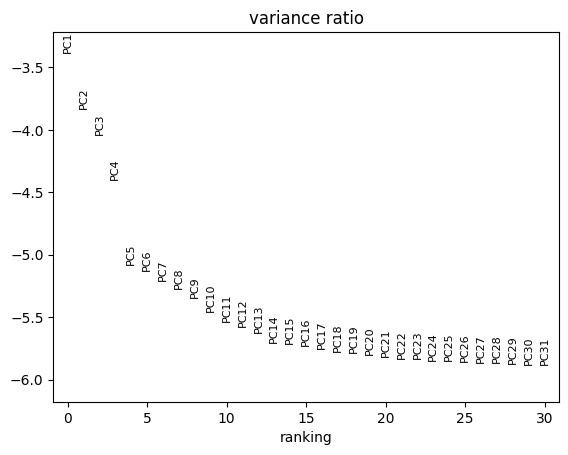

In [23]:
# Contribution of single PCs to the total variance in the data
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`
sc.pl.pca_variance_ratio(adata_nuclei, log=True)

In [24]:
adata_nuclei

AnnData object with n_obs × n_vars = 807761 × 480
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts'
    var: 'mean', 'std'
    uns: 'sopa_attrs', 'spatialdata_attrs', 'log1p', 'pca'
    obsm: 'spatial', 'tangram_pred', 'X_pca'
    varm: 'PCs'

In [25]:
# Group the PCs into a single AnnData object
X_nuc_pca = adata_nuclei.obsm["X_pca"][:, :14]

# As in MFA, divide the PCs by the square root of the maximal eigenvalue for each dataset separately
X_nuc_pca /= np.sqrt(np.max(adata_nuclei.uns["pca"]["variance"]))

# Save obs
nuclei_obs_all = adata_nuclei.obs.copy()

In [26]:
# Check var of first PC for each table is 1
print(np.var(adata_nuclei.obsm["X_pca"][:, 0]))

0.999999


In [27]:
# Have a look to all the PCs var in the combined data
print("Nuc:")
for i in range(14):
    print(f"PC {i} variance: {np.var(adata_nuclei.obsm['X_pca'][:, i])}")

Nuc:
PC 0 variance: 0.9999989867210388
PC 1 variance: 0.6412975192070007
PC 2 variance: 0.5186591148376465
PC 3 variance: 0.3629677891731262
PC 4 variance: 0.18442405760288239
PC 5 variance: 0.17525318264961243
PC 6 variance: 0.1619974970817566
PC 7 variance: 0.15131790935993195
PC 8 variance: 0.1409897804260254
PC 9 variance: 0.12579190731048584
PC 10 variance: 0.11667998135089874
PC 11 variance: 0.1120753064751625
PC 12 variance: 0.10687444359064102
PC 13 variance: 0.09820733219385147


In [28]:
# Clean memory
del adata_nuclei
gc.collect()

5274

##### Cyto :

In [29]:
adata_cyto = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cyto_{slide_id}.h5ad")

In [30]:
# Preprocess the data
sc.pp.normalize_total(adata_cyto, target_sum=1e4)
sc.pp.log1p(adata_cyto)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [31]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_cyto, max_value=10)

In [32]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_cyto, svd_solver="arpack", use_highly_variable=False)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


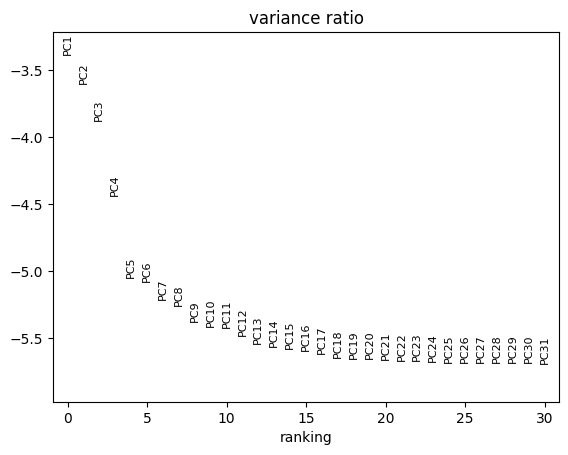

In [33]:
# Contribution of single PCs to the total variance in the data
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`
sc.pl.pca_variance_ratio(adata_cyto, log=True)

In [34]:
adata_cyto

AnnData object with n_obs × n_vars = 807761 × 480
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [35]:
# Group the PCs into a single AnnData object
X_cyto_pca = adata_cyto.obsm["X_pca"][:, :14]

# As in MFA, divide the PCs by the square root of the maximal eigenvalue for each dataset separately
X_cyto_pca /= np.sqrt(np.max(adata_cyto.uns["pca"]["variance"]))

# Check that obs_names align
assert np.array_equal(nuclei_obs_all['cell_id'].values, adata_cyto.obs['cell_id'].values), "Cell IDs do not match"

# Concatenate along columns (features) and keep only informative PCs
X_combined = np.concatenate([X_nuc_pca, X_cyto_pca], axis=1)

# Create a new AnnData to store these fused PCs
adata_combined = ad.AnnData(X=X_combined, obs=nuclei_obs_all.copy())

# Name the columns
adata_combined.var_names = [f"PC_nuc_{i}" for i in range(len(X_nuc_pca[0]))] + [f"PC_cyto_{i}" for i in range(len(X_cyto_pca[0]))]

In [36]:
# Check var of first PC for each table is 1
print(np.var(adata_cyto.obsm["X_pca"][:, 0]))

0.9999985


In [37]:
# Have a look to all the PCs var in the combined data
print("Cyto:")
for i in range(14):
    print(f"PC {i} variance: {np.var(adata_cyto.obsm['X_pca'][:, i])}")

Cyto:
PC 0 variance: 0.9999985098838806
PC 1 variance: 0.8078432083129883
PC 2 variance: 0.6104713678359985
PC 3 variance: 0.3486486077308655
PC 4 variance: 0.18925902247428894
PC 5 variance: 0.18365608155727386
PC 6 variance: 0.16054153442382812
PC 7 variance: 0.15384730696678162
PC 8 variance: 0.13700465857982635
PC 9 variance: 0.131423681974411
PC 10 variance: 0.13027319312095642
PC 11 variance: 0.12310691177845001
PC 12 variance: 0.1156708374619484
PC 13 variance: 0.11330971866846085


In [38]:
# Clean memory
del adata_cyto
gc.collect()

0

In [39]:
# Add final labels coming from table nuclei and table cells

adata_combined.obs['transcript_cat'] = adata_combined.obs['cell_id'].map(cellid2transcript_cat).fillna('Unknown')

adata_combined.obs['final_label_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')
adata_combined.obs['final_label_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')

adata_combined.obs['label1_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel1).fillna('Unknown')
adata_combined.obs['label1_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel1).fillna('Unknown')

adata_combined.obs

region   slide     cell_id       area  \
aaaaaaaa-1  nucleus_boundaries  morpho  aaaaaaaa-1  41.002191   
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  50.146767   
aaaaaaac-1  nucleus_boundaries  morpho  aaaaaaac-1  39.986850   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1  23.390865   
aaaaaaae-1  nucleus_boundaries  morpho  aaaaaaae-1  42.130546   
...                        ...     ...         ...        ...   
aaamfigm-1  nucleus_boundaries  morpho  aaamfigm-1  24.157193   
aaamfign-1  nucleus_boundaries  morpho  aaamfign-1  16.346013   
aaamfigo-1  nucleus_boundaries  morpho  aaamfigo-1  15.624592   
aaamfiha-1  nucleus_boundaries  morpho  aaamfiha-1   6.570084   
aaamfihc-1  nucleus_boundaries  morpho  aaamfihc-1  19.034179   

                                 ct_tangram  transcript_counts  \
aaaaaaaa-1           L5/6 excitatory neuron                169   
aaaaaaab-1           Protoplasmic astrocyte                161   
aaaaaaac-1                  Oligodendrocyte                203   
aaaaaaad-1                 Endothelial cell                 41   
aaaaaaae-1  Oligodendrocyte progenitor cell                179   
...                                     ...                ...   
aaamfigm-1           L2/3 excitatory neuron                 25   
aaamfign-1                 Endothelial cell                 22   
aaamfigo-1                 Endothelial cell                 17   
aaamfiha-1  Oligodendrocyte progenitor cell                 14   
aaamfihc-1                  Oligodendrocyte                 15   

            transcript_cat final_label_nuclei final_label_cells  \
aaaaaaaa-1               4       Glioblastoma      Glioblastoma   
aaaaaaab-1               5       Glioblastoma      Glioblastoma   
aaaaaaac-1               6       Glioblastoma      Glioblastoma   
aaaaaaad-1               0       Blood_vessel      Blood_vessel   
aaaaaaae-1               5       Glioblastoma      Glioblastoma   
...                    ...                ...               ...   
aaamfigm-1               0       Glioblastoma      Glioblastoma   
aaamfign-1               0       Blood_vessel      Blood_vessel   
aaamfigo-1               0            Myeloid           Myeloid   
aaamfiha-1               0       Glioblastoma      Glioblastoma   
aaamfihc-1               0       Glioblastoma      Glioblastoma   

                                        label1_nuclei  \
aaaaaaaa-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaab-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaac-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaad-1                                Endothelial   
aaaaaaae-1  Glioblastoma_tumor_cell_astrocyte_derived   
...                                               ...   
aaamfigm-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaamfign-1                                Endothelial   
aaamfigo-1                                 Macrophage   
aaamfiha-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaamfihc-1  Glioblastoma_tumor_cell_astrocyte_derived   

                                         label1_cells  
aaaaaaaa-1  Glioblastoma_tumor_cell_astrocyte_derived  
aaaaaaab-1  Glioblastoma_tumor_cell_astrocyte_derived  
aaaaaaac-1  Glioblastoma_tumor_cell_astrocyte_derived  
aaaaaaad-1                               Blood_vessel  
aaaaaaae-1  Glioblastoma_tumor_cell_astrocyte_derived  
...                                               ...  
aaamfigm-1  Glioblastoma_tumor_cell_astrocyte_derived  
aaamfign-1                               Blood_vessel  
aaamfigo-1                                    Myeloid  
aaamfiha-1  Glioblastoma_tumor_cell_astrocyte_derived  
aaamfihc-1  Glioblastoma_tumor_cell_astrocyte_derived  

[807761 rows x 11 columns]

In [40]:
adata_combined

AnnData object with n_obs × n_vars = 807761 × 28
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'

In [41]:
adata_combined.var

Empty DataFrame
Columns: []
Index: [PC_nuc_0, PC_nuc_1, PC_nuc_2, PC_nuc_3, PC_nuc_4, PC_nuc_5, PC_nuc_6, PC_nuc_7, PC_nuc_8, PC_nuc_9, PC_nuc_10, PC_nuc_11, PC_nuc_12, PC_nuc_13, PC_cyto_0, PC_cyto_1, PC_cyto_2, PC_cyto_3, PC_cyto_4, PC_cyto_5, PC_cyto_6, PC_cyto_7, PC_cyto_8, PC_cyto_9, PC_cyto_10, PC_cyto_11, PC_cyto_12, PC_cyto_13]

## 4. PCA on the two separated PCA (late fusion) + Clustering

In [42]:
# Run a "second PCA" on the scaled features
# No scaling because we already scaled using the maximum eigenvalue for each table
sc.tl.pca(adata_combined)

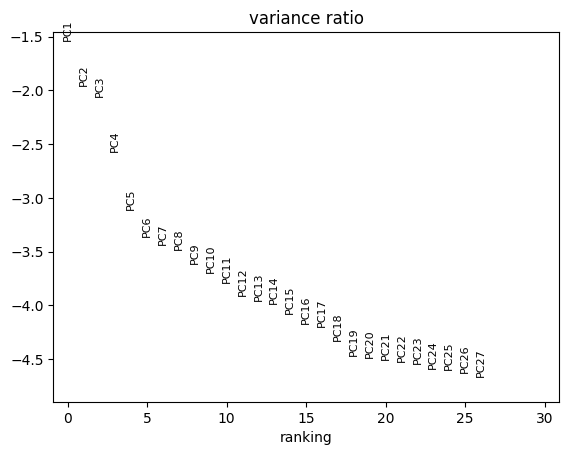

In [43]:
sc.pl.pca_variance_ratio(adata_combined, log=True)

In [44]:
adata_combined

AnnData object with n_obs × n_vars = 807761 × 28
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [45]:
# Neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=19, use_rep="X_pca", key_added='pca_n10_pcs19')
# Embedding the neighborhood graph using UMAP
sc.tl.umap(adata_combined, neighbors_key='pca_n10_pcs19')
# Leiden clustering directly clusters the neighborhood graph of cells
sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs19_leiden_res0.4', neighbors_key='pca_n10_pcs19')
sc.tl.leiden(adata_combined, resolution=0.6, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs19_leiden_res0.6', neighbors_key='pca_n10_pcs19')
sc.tl.leiden(adata_combined, resolution=0.8, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs19_leiden_res0.8', neighbors_key='pca_n10_pcs19')

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_54346/3617132630.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs19_leiden_res0.4', neighbors_key='pca_n10_pcs19')


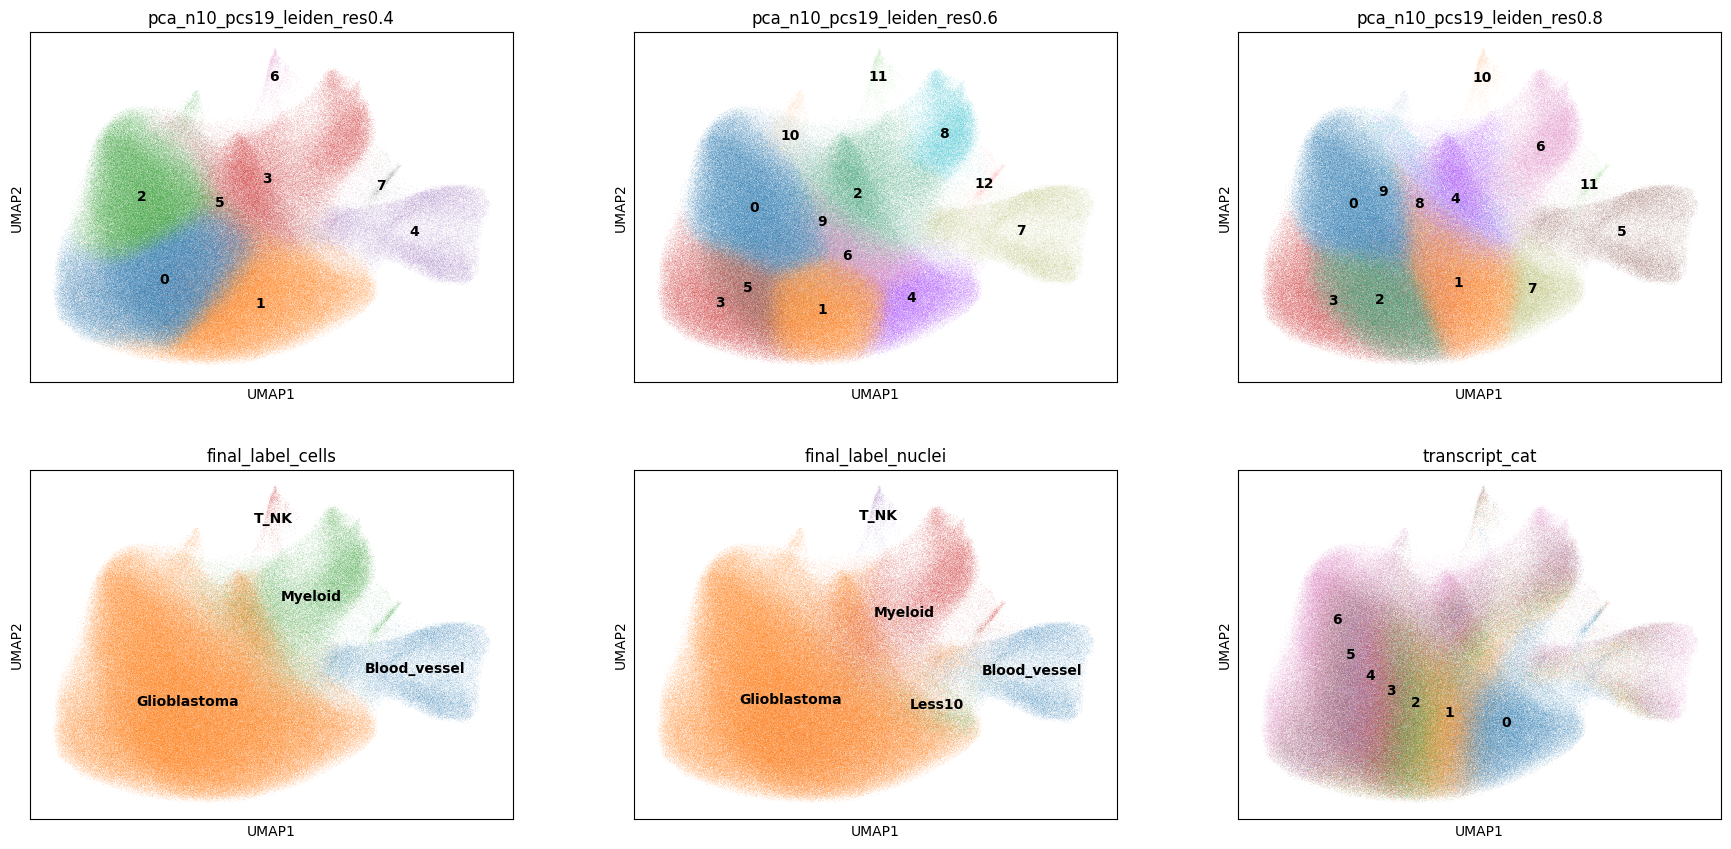

In [46]:
# Plot the clusters
adata_combined.obs['transcript_cat'] = pd.Categorical(adata_combined.obs['transcript_cat'])
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs19',
           color=['pca_n10_pcs19_leiden_res0.4', 'pca_n10_pcs19_leiden_res0.6', 'pca_n10_pcs19_leiden_res0.8', 'final_label_cells', 'final_label_nuclei', 'transcript_cat'],
           ncols=3, legend_loc='on data')

In [47]:
clustering_label = 'pca_n10_pcs19_leiden_res0.6'

In [48]:
adata_cells = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cells_{slide_id}.h5ad")

In [49]:
# Put the clustering_label into the adata_cells to be able to use marker genes, and also final_label_cells and final_label_nuclei
cellid2clustering_label = dict(adata_combined.obs[['cell_id', clustering_label]].values)
adata_cells.obs["cluster_combined"] = adata_cells.obs['cell_id'].map(cellid2clustering_label).fillna('Unknown')
adata_cells.obs["final_label_cells"] = adata_cells.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')
adata_cells.obs["final_label_nuclei"] = adata_cells.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')


# Preprocess the adata_cells
sc.pp.normalize_total(adata_cells, target_sum=1e4)
sc.pp.log1p(adata_cells)

# Add X_umap to adata_cells, checking before cell_id alignment
assert np.array_equal(adata_cells.obs['cell_id'].values, adata_combined.obs['cell_id'].values), "Cell IDs do not match"
adata_cells.obsm['X_umap'] = adata_combined.obsm['X_umap']

# Wilcoxon rank-sum (Mann-Whitney-U) test. 
# You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.
sc.tl.rank_genes_groups(adata_cells, "cluster_combined", method="wilcoxon", corr_method="benjamini-hochberg", key_added="rank_genes_"+"cluster_combined")
# The top ranked genes per cluster
top_ranked_genes = pd.DataFrame(adata_cells.uns["rank_genes_"+"cluster_combined"]["names"]).iloc[:7, :]
list_genes = pd.concat([top_ranked_genes[col] for col in top_ranked_genes], ignore_index=True).tolist()

## 5. Analyze and get combined labels

### Helper functions

In [50]:
def analyze_clusters(adata, resolution_key):
    
    # Ensure the resolution key exists in obs
    if resolution_key not in adata.obs:
        raise ValueError(f"{resolution_key} not found in adata.obs.")
    
    # Group data by the specified clustering resolution
    cluster_groups = adata.obs.groupby(resolution_key)

    results = {}

    for cluster_id, group in cluster_groups:
        
        # Calculate dominant labels for final_label_cells
        label_cells_counts = group['final_label_cells'].value_counts(normalize=True)
        dominant_cells = label_cells_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for cells
        label1_cells_counts = group['label1_cells'].value_counts(normalize=True)
        top1_cells = label1_cells_counts.head(1) * 100

        # Calculate dominant labels for final_label_nuclei
        label_nuclei_counts = group['final_label_nuclei'].value_counts(normalize=True)
        dominant_nuclei = label_nuclei_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for nuclei
        label1_nuclei_counts = group['label1_nuclei'].value_counts(normalize=True)
        top1_nuclei = label1_nuclei_counts.head(1) * 100
        if top1_nuclei.keys()[0] == 'less_10_rna':
            top1_nuclei = label1_nuclei_counts.head(2).tail(1) * 100
        
        # Align categories for comparison
        common_categories = group['final_label_cells'].cat.categories.union(group['final_label_nuclei'].cat.categories)
        group['final_label_cells'] = group['final_label_cells'].cat.set_categories(common_categories)
        group['final_label_nuclei'] = group['final_label_nuclei'].cat.set_categories(common_categories)

        # Count different labels between final_label_cells and final_label_nuclei
        total_cells = len(group)  # Total number of cells in the cluster
        differing_labels_count_woUnknown = ((group['final_label_cells'] != group['final_label_nuclei']) & (group['final_label_nuclei'] != 'Unknown')  & (group['final_label_nuclei'] != 'Less10')).sum() / total_cells * 100
        differing_labels_count = (group['final_label_cells'] != group['final_label_nuclei']).sum() / total_cells * 100

        # Store the results
        results[cluster_id] = (dominant_cells.to_dict(), dominant_nuclei.to_dict(), top1_cells.to_dict(), top1_nuclei.to_dict(), differing_labels_count_woUnknown, differing_labels_count)

    return results

In [51]:
def analyze_cluster_dominance(cluster_analysis_results):
    
    clusters_unknown_cells = []
    clusters_different_top1 = []
    clusters_high_diff = []

    for cluster_id, (dominant_cells, dominant_nuclei, label1_cells, label1_nuclei, diff_percentage_woUnknown, _) in cluster_analysis_results.items():
        
        # Check if top 1 dominant_cells is 'Unknown' or 'Less10'
        
        top1_dominant_cells = max(dominant_cells, key=dominant_cells.get)
        if top1_dominant_cells == 'Unknown' or top1_dominant_cells == 'Less10':
            clusters_unknown_cells.append(cluster_id)
        
        # Check if top 1 for dominant_cells is different from dominant_nuclei
        
        top1_dominant_nuclei = max(dominant_nuclei, key=dominant_nuclei.get)

        if top1_dominant_nuclei == 'Unknown' or top1_dominant_nuclei == 'Less10':
            sorted_nuclei = sorted(dominant_nuclei.items(), key=lambda x: x[1], reverse=True)
            if len(sorted_nuclei) > 1:  # Make sure there's a second element
                top1_dominant_nuclei = sorted_nuclei[1][0]

        if top1_dominant_cells != top1_dominant_nuclei:
            clusters_different_top1.append(cluster_id)
        
        # Check if diff_percentage_woUnknown is greater than 40%
        
        if diff_percentage_woUnknown > 40:
            clusters_high_diff.append(cluster_id)

    print(f"Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': {clusters_unknown_cells}")
    print(f"Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): {clusters_different_top1}")
    print(f"Clusters where diff_percentage_woUnknown is greater than 40%: {clusters_high_diff}")

    print("=" * 50)

    clusters_to_analyse = set(clusters_unknown_cells + clusters_different_top1 + clusters_high_diff)
    for cluster_id in clusters_to_analyse:
        print(f"\nCluster ID: {cluster_id}")
        print(f"Dominant final_label_cells: {cluster_analysis_results[cluster_id][0]} - with dominant label1: {cluster_analysis_results[cluster_id][2]}")
        print(f"Dominant final_label_nuclei: {cluster_analysis_results[cluster_id][1]} - with dominant label1: {cluster_analysis_results[cluster_id][3]}")
        print(f"Count of differing labels without 'Unknown' or 'Less10' label for Nuclei: {round(cluster_analysis_results[cluster_id][4], 2)} %")
        print(f"Count of differing labels: {round(cluster_analysis_results[cluster_id][5], 2)} %")
        print(f"% of cells in cluster: {round(len(adata_combined.obs[adata_combined.obs[clustering_label] == cluster_id]) / len(adata_combined.obs) * 100, 2)} %")
        print("-----")

In [52]:
def assign_final_labels(cluster_analysis_results, input_dict):
    
    dict_combined_labels = {}

    for cluster_id, (dominant_cells, _, _, _, _, _) in cluster_analysis_results.items():
        
        if cluster_id in input_dict:
            # Use the label from input_dict if cluster_id is in it
            dict_combined_labels[cluster_id] = input_dict[cluster_id]
        else:
            # Otherwise, use the dominant label from final_label_cells
            dict_combined_labels[cluster_id] = max(dominant_cells, key=dominant_cells.get)

    return dict_combined_labels

### Analysis

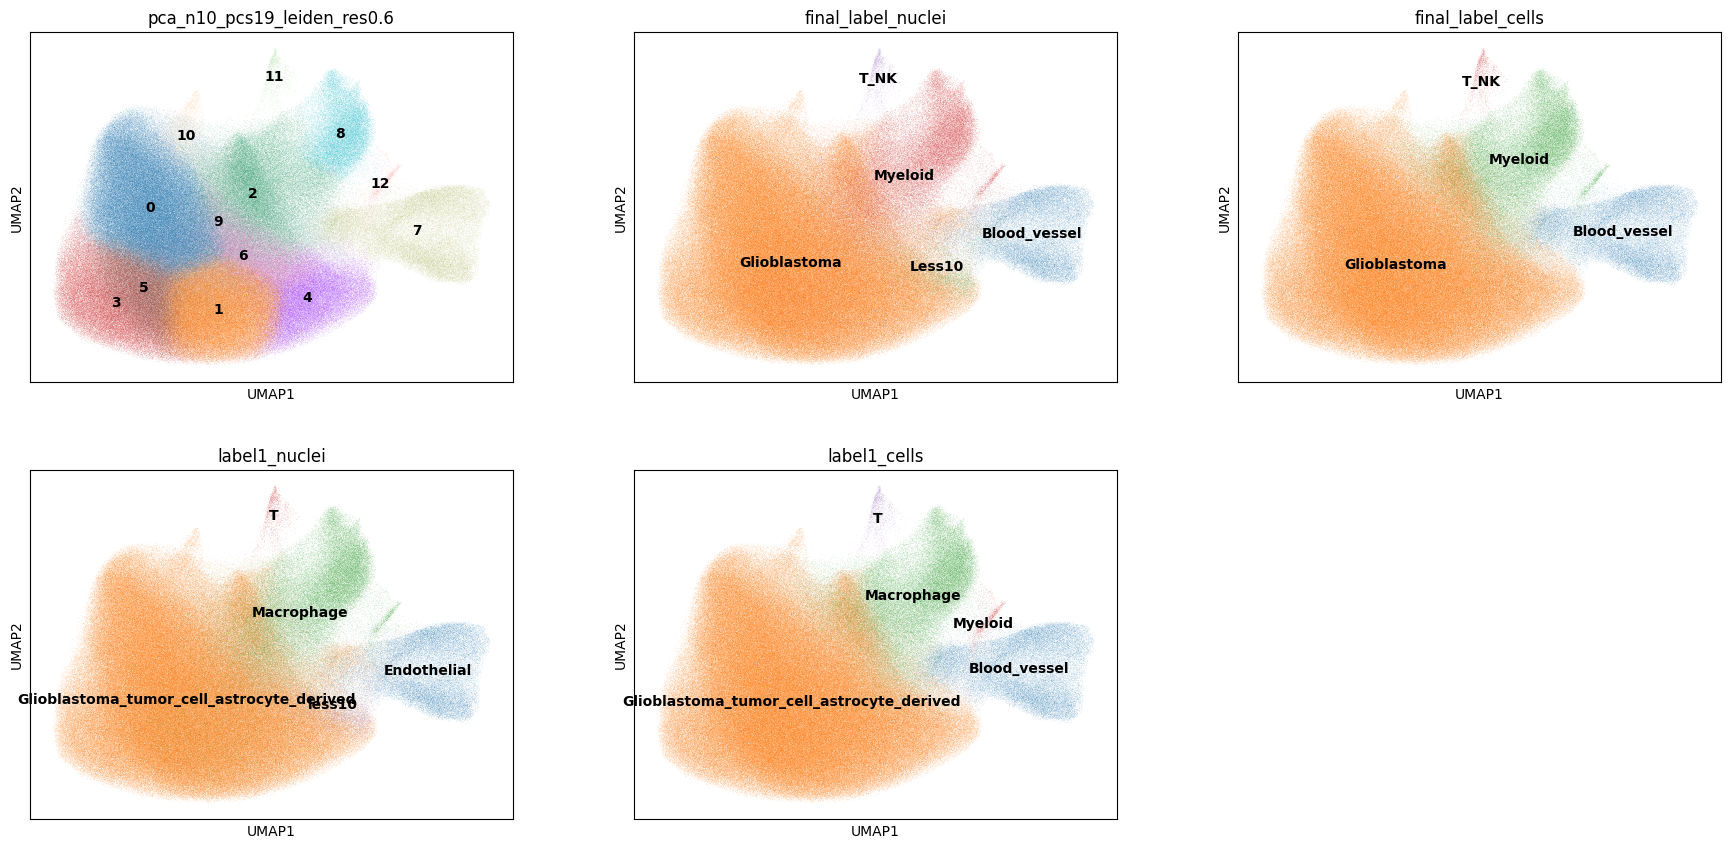

In [53]:
# Plot the clusters
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs19',
           color=[clustering_label, 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'],
           ncols=3, legend_loc='on data')

In [54]:
cluster_analysis_results = analyze_clusters(adata_combined, clustering_label)

for cluster_id, (dominant_cells, dominant_nuclei, _, _, diff_count_woUnknown, diff_count) in cluster_analysis_results.items():
    print("=" * 50)
    print(f"Cluster ID: {cluster_id}")
    print(f"Dominant final_label_cells: {dominant_cells}")
    print(f"Dominant final_label_nuclei: {dominant_nuclei}")
    print(f"Count of differing labels without 'Unknown/Less10' label for Nuclei: {round(diff_count_woUnknown, 2)} %")
    print(f"Count of differing labels: {round(diff_count, 2)} %\n")

Cluster ID: 0
Dominant final_label_cells: {'Glioblastoma': 99.51283511655343, 'Blood_vessel': 0.2400227818233595}
Dominant final_label_nuclei: {'Glioblastoma': 98.8131076847972, 'Myeloid': 1.096883772019039}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 1.52 %
Count of differing labels: 1.54 %

Cluster ID: 1
Dominant final_label_cells: {'Glioblastoma': 99.49803764332144, 'Blood_vessel': 0.3801343192665644}
Dominant final_label_nuclei: {'Glioblastoma': 96.29041336715733, 'Myeloid': 3.4466539698205736}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 3.99 %
Count of differing labels: 3.99 %

Cluster ID: 2
Dominant final_label_cells: {'Glioblastoma': 59.9169504968973, 'Myeloid': 39.55115942705174}
Dominant final_label_nuclei: {'Glioblastoma': 57.58689870760043, 'Myeloid': 41.499556758269954}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 25.73 %
Count of differing labels: 26.25 %

Cluster ID: 3
Dominant final_label_cells: {'

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_54346/1125182952.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_groups = adata.obs.groupby(resolution_key)


In [55]:
analyze_cluster_dominance(cluster_analysis_results)

Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': []
Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): []
Clusters where diff_percentage_woUnknown is greater than 40%: []


In [57]:
dict_combined_labels = assign_final_labels(cluster_analysis_results, {})
dict_combined_labels

{'0': 'Glioblastoma',
 '1': 'Glioblastoma',
 '2': 'Glioblastoma',
 '3': 'Glioblastoma',
 '4': 'Glioblastoma',
 '5': 'Glioblastoma',
 '6': 'Glioblastoma',
 '7': 'Blood_vessel',
 '8': 'Myeloid',
 '9': 'Glioblastoma',
 '10': 'Glioblastoma',
 '11': 'T_NK',
 '12': 'Myeloid'}

In [58]:
adata_combined.obs['final_label_combined'] = adata_combined.obs[clustering_label].map(dict_combined_labels)
adata_combined.obs

region   slide     cell_id       area  \
aaaaaaaa-1  nucleus_boundaries  morpho  aaaaaaaa-1  41.002191   
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  50.146767   
aaaaaaac-1  nucleus_boundaries  morpho  aaaaaaac-1  39.986850   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1  23.390865   
aaaaaaae-1  nucleus_boundaries  morpho  aaaaaaae-1  42.130546   
...                        ...     ...         ...        ...   
aaamfigm-1  nucleus_boundaries  morpho  aaamfigm-1  24.157193   
aaamfign-1  nucleus_boundaries  morpho  aaamfign-1  16.346013   
aaamfigo-1  nucleus_boundaries  morpho  aaamfigo-1  15.624592   
aaamfiha-1  nucleus_boundaries  morpho  aaamfiha-1   6.570084   
aaamfihc-1  nucleus_boundaries  morpho  aaamfihc-1  19.034179   

                                 ct_tangram  transcript_counts transcript_cat  \
aaaaaaaa-1           L5/6 excitatory neuron                169              4   
aaaaaaab-1           Protoplasmic astrocyte                161              5   
aaaaaaac-1                  Oligodendrocyte                203              6   
aaaaaaad-1                 Endothelial cell                 41              0   
aaaaaaae-1  Oligodendrocyte progenitor cell                179              5   
...                                     ...                ...            ...   
aaamfigm-1           L2/3 excitatory neuron                 25              0   
aaamfign-1                 Endothelial cell                 22              0   
aaamfigo-1                 Endothelial cell                 17              0   
aaamfiha-1  Oligodendrocyte progenitor cell                 14              0   
aaamfihc-1                  Oligodendrocyte                 15              0   

           final_label_nuclei final_label_cells  \
aaaaaaaa-1       Glioblastoma      Glioblastoma   
aaaaaaab-1       Glioblastoma      Glioblastoma   
aaaaaaac-1       Glioblastoma      Glioblastoma   
aaaaaaad-1       Blood_vessel      Blood_vessel   
aaaaaaae-1       Glioblastoma      Glioblastoma   
...                       ...               ...   
aaamfigm-1       Glioblastoma      Glioblastoma   
aaamfign-1       Blood_vessel      Blood_vessel   
aaamfigo-1            Myeloid           Myeloid   
aaamfiha-1       Glioblastoma      Glioblastoma   
aaamfihc-1       Glioblastoma      Glioblastoma   

                                        label1_nuclei  \
aaaaaaaa-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaab-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaac-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaad-1                                Endothelial   
aaaaaaae-1  Glioblastoma_tumor_cell_astrocyte_derived   
...                                               ...   
aaamfigm-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaamfign-1                                Endothelial   
aaamfigo-1                                 Macrophage   
aaamfiha-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaamfihc-1  Glioblastoma_tumor_cell_astrocyte_derived   

                                         label1_cells  \
aaaaaaaa-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaab-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaac-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaaaaaad-1                               Blood_vessel   
aaaaaaae-1  Glioblastoma_tumor_cell_astrocyte_derived   
...                                               ...   
aaamfigm-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaamfign-1                               Blood_vessel   
aaamfigo-1                                    Myeloid   
aaamfiha-1  Glioblastoma_tumor_cell_astrocyte_derived   
aaamfihc-1  Glioblastoma_tumor_cell_astrocyte_derived   

           pca_n10_pcs19_leiden_res0.4 pca_n10_pcs19_leiden_res0.6  \
aaaaaaaa-1                           0                           3   
aaaaaaab-1                           2                           0   
aaaaaaac-1                           2                           0   
aaaaaaa

In [59]:
adata_combined.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Glioblastoma    725059
Blood_vessel     45866
Myeloid          34521
T_NK              2315
Name: count, dtype: int64

In [60]:
# Create final table, adding cell_id with less than 10 transcripts

adata_nuclei_ini = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_ini_{slide_id}.h5ad")

adata_combined_missing = adata_nuclei_ini[~adata_nuclei_ini.obs_names.isin(adata_combined.obs_names)].copy()
adata_combined_missing.obs['final_label_combined'] = 'Less10'
adata_combined_missing.obs['final_label_nuclei'] = 'Less10'
adata_combined_missing.obs['final_label_cells'] = 'Less10'
print(adata_combined.shape[0] + adata_combined_missing.shape[0])

adata_combined_all = ad.concat([adata_combined, adata_combined_missing], join="outer", merge="first", uns_merge="first", pairwise=True)
print(adata_combined_all.shape[0])

809076
809076


In [61]:
# Clean memory
del adata_combined, adata_combined_missing, adata_nuclei_ini
gc.collect()

96167

In [62]:
adata_combined_all

AnnData object with n_obs × n_vars = 809076 × 569
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells', 'pca_n10_pcs19_leiden_res0.4', 'pca_n10_pcs19_leiden_res0.6', 'pca_n10_pcs19_leiden_res0.8', 'final_label_combined'
    uns: 'pca', 'pca_n10_pcs19', 'umap', 'pca_n10_pcs19_leiden_res0.4', 'pca_n10_pcs19_leiden_res0.6', 'pca_n10_pcs19_leiden_res0.8', 'pca_n10_pcs19_leiden_res0.4_colors', 'pca_n10_pcs19_leiden_res0.6_colors', 'pca_n10_pcs19_leiden_res0.8_colors', 'final_label_cells_colors', 'final_label_nuclei_colors', 'transcript_cat_colors', 'label1_nuclei_colors', 'label1_cells_colors', 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'X_pca', 'X_umap', 'spatial', 'tangram_pred'
    varm: 'PCs'
    obsp: 'pca_n10_pcs19_distances', 'pca_n10_pcs19_connectivities'

In [63]:
adata_combined_all.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Glioblastoma    725059
Blood_vessel     45866
Myeloid          34521
T_NK              2315
Less10            1315
Name: count, dtype: int64

In [64]:
sdata_final = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('shapes',))

In [65]:
# Add in sdata final
sdata_final.tables['table_combined'] = adata_combined_all

In [66]:
adata_combined_all

AnnData object with n_obs × n_vars = 809076 × 569
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells', 'pca_n10_pcs19_leiden_res0.4', 'pca_n10_pcs19_leiden_res0.6', 'pca_n10_pcs19_leiden_res0.8', 'final_label_combined'
    uns: 'pca', 'pca_n10_pcs19', 'umap', 'pca_n10_pcs19_leiden_res0.4', 'pca_n10_pcs19_leiden_res0.6', 'pca_n10_pcs19_leiden_res0.8', 'pca_n10_pcs19_leiden_res0.4_colors', 'pca_n10_pcs19_leiden_res0.6_colors', 'pca_n10_pcs19_leiden_res0.8_colors', 'final_label_cells_colors', 'final_label_nuclei_colors', 'transcript_cat_colors', 'label1_nuclei_colors', 'label1_cells_colors', 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'X_pca', 'X_umap', 'spatial', 'tangram_pred'
    varm: 'PCs'
    obsp: 'pca_n10_pcs19_distances', 'pca_n10_pcs19_connectivities'

In [67]:
# Convert in str the final_label_combined, final_label_cells and final_label_nuclei to see it in Napari
sdata_final.tables['table_combined'].obs['final_label_combined'] = sdata_final.tables['table_combined'].obs['final_label_combined'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_cells'] = sdata_final.tables['table_combined'].obs['final_label_cells'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_nuclei'] = sdata_final.tables['table_combined'].obs['final_label_nuclei'].astype(str)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


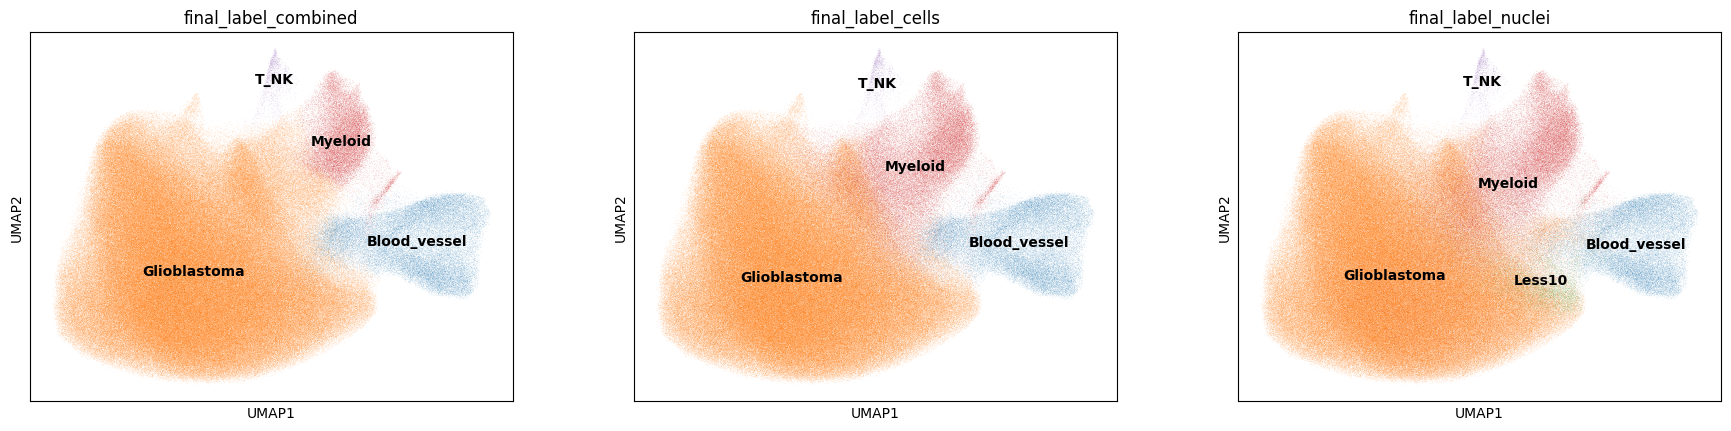

In [68]:
sc.pl.umap(sdata_final.tables['table_combined'], color=['final_label_combined', 'final_label_cells', 'final_label_nuclei'], ncols=3, legend_loc='on data')

In [69]:
# Put table_combined as annotating cell_boundaries

sdata_final["table_combined"].obs["region"] = "cell_boundaries"
sdata_final.tables["table_combined"].obs['region'] = sdata_final.tables["table_combined"].obs['region'].astype('category')
sdata_final.set_table_annotates_spatialelement(table_name="table_combined", region="cell_boundaries", region_key="region", instance_key="cell_id")

region, region_key, instance_key = get_table_keys(sdata_final["table_combined"])
print(region, region_key, instance_key)

cell_boundaries region cell_id


In [70]:
# Color for final label in Napari

to_hex = partial(colors.to_hex, keep_alpha=True)

# Normalize the RGB values to the range [0, 1] by dividing by 255
napari_color = {
                "T_NK": to_hex(to_rgba([255/255, 15/255, 15/255])[:3]),                      # Red
                "B_Plasma": to_hex(to_rgba([255/255, 143/255, 15/255])[:3]),                 # Orange
                "Myeloid": to_hex(to_rgba([255/255, 211/255, 15/255])[:3]),                  # Yellow
                "Blood_vessel": to_hex(to_rgba([70/255, 128/255, 0/255])[:3]),               # Dark Green
                "Fibroblast_Myofibroblast": to_hex(to_rgba([156/255, 255/255, 36/255])[:3]), # Light Green
                "Epithelial": to_hex(to_rgba([57/255, 208/255, 133/255])[:3]),               # Blue Green
                "Specialized": to_hex(to_rgba([69/255, 237/255, 255/255])[:3]),              # Turquoise
                "Melanocyte": to_hex(to_rgba([22/255, 169/255, 223/255])[:3]),               # Blue
                "Stem_like": to_hex(to_rgba([22/255, 69/255, 223/255])[:3]),                 # Dark Blue
                "Glioblastoma": to_hex(to_rgba([130/255, 55/255, 235/255])[:3]),             # Purple
                "Unknown": to_hex(to_rgba([0/255, 0/255, 0/255])[:3]),                       # Black
                "Less10": to_hex(to_rgba([143/255, 143/255, 143/255])[:3])                   # Grey
                }

sdata_final.tables['table_combined'].uns["final_label_combined_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_cells_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_nuclei_colors"] = napari_color

In [71]:
sdata_final.write_element("table_combined")